In [1]:
import struct
from pynq import Overlay
from pynq import DefaultIP
class AddDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:trapezoidal:1.0']

    def getfreq(self, nc, k, en):
        trapezoidal.write(0x10,nc) 
        trapezoidal.write(0x18,struct.pack("f", k)) #mimo can only use int ot byte, so converting to byte...
        trapezoidal.write(0x28,en)
        trapezoidal.write(0x00,1)
        while(not(trapezoidal.read(0x24)&1)):
            1
        return struct.unpack("f", struct.pack("I", trapezoidal.read(0x20)))[0] #mimo can only use int ot byte, so converting from byte...
overlay=Overlay('/home/xilinx/pynq/overlays/PWMtest/trapezoidal.bit')
trapezoidal=overlay.trapezoidal
motionplanner=overlay.motion_planner

Trapezoidal generation time for  9000  values:  2.15474796295166  Seconds
Average Single Value Execution time:  0.00023941644032796224 Seconds


<IPython.core.display.Javascript object>


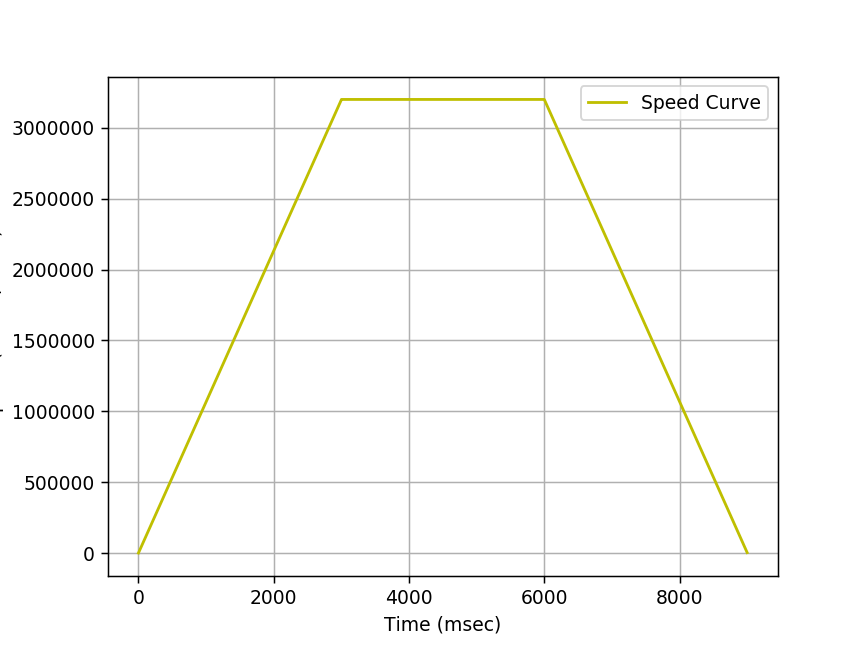

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
#Plotting function
def plot_to_notebook(time_msec,in_signal,n_samples):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.ylabel('Speed (Pulses/msec)')
    plt.grid()
    plt.plot(time_msec,in_signal[:n_samples],'y-',label='Speed Curve')
    plt.legend()
# S-Curve Settings
#planmotion(3200,2133,45)
motionplanner.write(0x10,3200) #Vm
motionplanner.write(0x18,2133) #accel_deccel
motionplanner.write(0x20,45) #rev
motionplanner.write(0x00,1)
nc=0
k=1
en=1
samples=[]
# Total time
T =motionplanner.read(0x28) #T
# Number of samples
n = T
# Time vector in milli-seconds
t = np.linspace(0, T, n, endpoint=False)
start_time = time.time()
for (nc) in range(T):
    samples.append(trapezoidal.getfreq(nc,k,en))
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Trapezoidal generation time for ',T,' values: ',sw_exec_time,' Seconds')   
print ('Average Single Value Execution time: ',sw_exec_time/T, 'Seconds')
plot_to_notebook(t,samples,n)

In [3]:
import time
import numpy as np
from matplotlib import pyplot as plt

class LivePlotNotebook(object):

    def __init__(self):
        %matplotlib notebook
        fig,ax = plt.subplots(1,1)
        
        ax.plot([0]*20, label='speed')
        #ax.plot([1]*20, [1]*20, 'o', ms=12,c='gray', label='hold')
        #ax.plot([0]*20, [0]*20, '^', ms=12,c='blue', label='buy' )
        #ax.plot([0]*20, [0]*20, 'v', ms=12,c='red', label='sell')
        
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.legend()
        ax.set_xlabel('time')
        ax.grid()
        ax.set_title('Real Time Motion')
        
        self.ax = ax
        self.fig = fig

    def update(self, x, actions):             
        # update price
        line = self.ax.lines[0]
        line.set_xdata(range(len(x)))
        line.set_ydata(x)
        
        # update action plots
        for i, line in enumerate(self.ax.lines[1:]):
            line.set_xdata(np.argwhere(actions==i).T)
            line.set_ydata(x[actions==i])
            #line.set_marker(['o','^','v'][i])

        # update limits
        self.ax.set_xlim(0, len(actions))
        self.ax.set_ylim(x.min(), x.max())

        self.fig.canvas.draw()
        

<IPython.core.display.Javascript object>


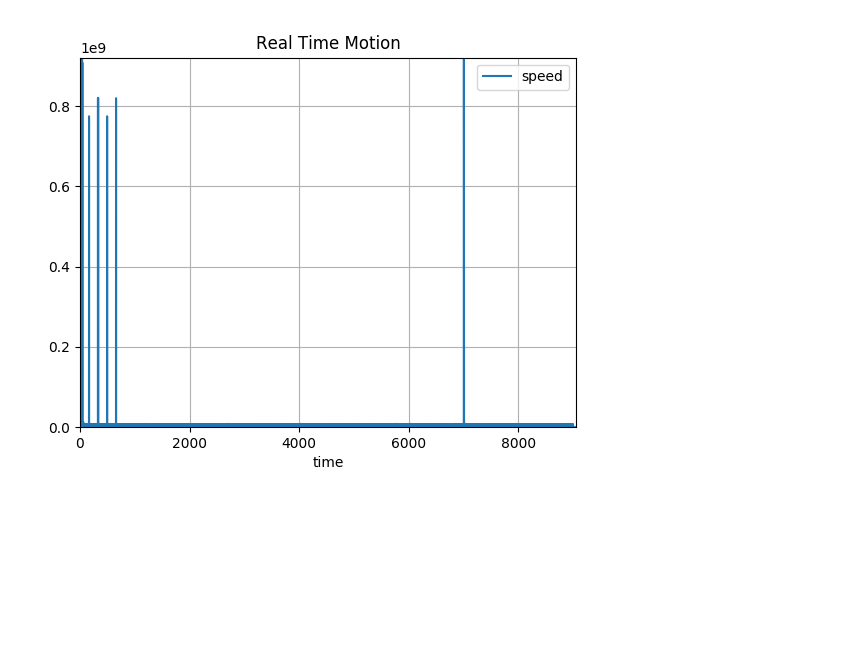

KeyboardInterrupt: 

In [ ]:
motionplanner.write(0x10,3200) #Vm
motionplanner.write(0x18,2133) #accel_deccel
motionplanner.write(0x20,45) #rev
motionplanner.write(0x00,1)
Vm=3200000
nc=0
k=0.00625
en=1
T =motionplanner.read(0x28)
liveplot = LivePlotNotebook()
x=np.empty(T,dtype=int)
y=np.empty(T,dtype=float)
while(1):
    nc=0
    for(nc) in range (T): 
        y=np.append(y,trapezoidal.getfreq(nc,k,en))
        x=np.append(x,nc)
        liveplot.update(x,y)
        time.sleep(0.1)